In [ ]:
# installed an older version of pytorch to stop an error message
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 42.2MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTS
import fastai
import torch
import torchvision
from fastai.vision import *
from fastai.callbacks import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
bs = 32
ds_tfms = get_transforms()

# IMPORTING THE DATASET
data = (ImageList.from_folder('/content/drive/My Drive/CSC400/Train and Test Split Data/')  
        .split_by_folder(train='train', valid='val')         # splitting the data
        .label_from_folder()                                # data is labelled based on the folder name
        .transform(tfms=get_transforms(), size=(128,128))   # resize images here
        .databunch(bs=bs))

data

ImageDataBunch;

Train: LabelList (5126 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
glioma,glioma,glioma,glioma,glioma
Path: /content/drive/My Drive/CSC400/Train and Test Split Data;

Valid: LabelList (1708 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
glioma,glioma,glioma,glioma,glioma
Path: /content/drive/My Drive/CSC400/Train and Test Split Data;

Test: None

In [ ]:
data_test = (ImageList.from_folder('/content/drive/My Drive/CSC400/Train and Test Split Data/')
            .split_by_folder(train='train', valid='test')
            .label_from_folder()
            .transform(tfms=get_transforms(), size=(128,128))
            .databunch(bs=bs))
data_test

ImageDataBunch;

Train: LabelList (5126 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
glioma,glioma,glioma,glioma,glioma
Path: /content/drive/My Drive/CSC400/Train and Test Split Data;

Valid: LabelList (1710 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
glioma,glioma,glioma,glioma,glioma
Path: /content/drive/My Drive/CSC400/Train and Test Split Data;

Test: None

In [ ]:
print(data.classes)

['glioma', 'meningioma', 'pituitary']


In [ ]:
class BT_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 8, 3, stride=1)     # input size: bs x 3x512x512       output size: bs x 16x255x255
        #maxpool                                                                         # output size: bs x 16x127x127                                     
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1)   # input size: bs x 16x127x127       output size: bs x 32x63x63
        #maxpool                                      # output size: bs x 32x30x30
        self.conv3 = nn.Conv2d(16, 32, 3)      # input size: bs x 32x30x30      output size: bs x 64x28x28
        #maxpool                                      # output size: bs x 64x14x14
        self.conv4 = nn.Conv2d(32, 64, 3)     # input size: bs x 64x14x14       output size: bs x 128x12x12
        self.conv5 = nn.Conv2d(64, 128, 3)  # input size: bs x 
        self.maxpool = nn.MaxPool2d(2, 2)   #                                   output size: bs x 128x6x6
        self.lin1 = nn.Linear(128*2*2, 256, bias=True) # input size: bs x 192x31x31    output size: 1000
        self.dropout = nn.Dropout(p=0.5)
        self.lin2 = nn.Linear(256, 3, bias=True)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        #x = self.bnorm1(x)
        x = self.maxpool(F.relu(self.conv2(x)))
        #x = self.bnorm2(x)
        x = self.maxpool(F.relu(self.conv3(x)))
        #x = self.bnorm3(x)
        x = self.maxpool(F.relu(self.conv4(x)))
        #x = self.bnorm4(x)
        x = self.maxpool(F.relu(self.conv5(x)))
        x = x.view(-1, self.lin1.in_features)   # reshapes the tensor to appropriate dimensions
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        return self.lin2(x)

In [ ]:
print(BT_CNN())

BT_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=115200, out_features=1800, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (lin2): Linear(in_features=1800, out_features=3, bias=True)
)


In [ ]:
learner = Learner(data=data, model=BT_CNN(), loss_func=nn.CrossEntropyLoss(), metrics=[accuracy, error_rate, Precision(), Recall()], callback_fns=[CSVLogger])

epoch,train_loss,valid_loss,accuracy,error_rate,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


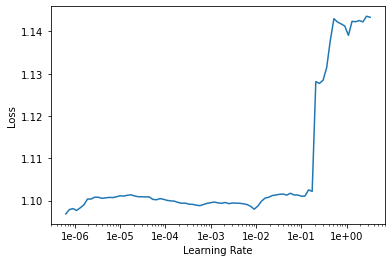

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(25, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,precision,recall,time
0,1.098500,1.098542,0.331382,0.668618,nan,0.333333,01:02
1,1.058459,0.945556,0.549180,0.450820,0.664305,0.547895,01:02
2,0.838741,0.718625,0.708431,0.291569,0.727685,0.707800,01:02
3,0.802197,0.661461,0.707845,0.292155,0.710618,0.707291,01:02
4,0.779162,0.671719,0.717213,0.282787,0.729362,0.716700,01:02
5,0.731189,0.606140,0.733021,0.266979,0.736839,0.732419,01:01
6,0.710507,0.605332,0.745316,0.254684,0.759959,0.744686,01:00
7,0.671226,0.512599,0.778689,0.221311,0.775909,0.778194,01:01
8,0.661114,0.494152,0.793911,0.206089,0.792242,0.793447,01:01
9,0.568841,0.507695,0.792155,0.207845,0.810819,0.792294,01:01


/usr/local/lib/python3.7/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [ ]:
#learner.export()

In [ ]:
#res = learner.csv_logger.read_logged_file()
#results = res.to_numpy()

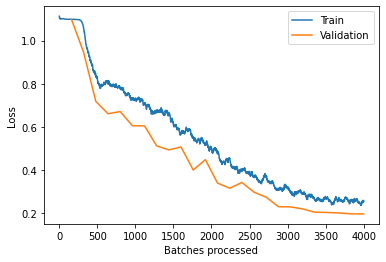

In [ ]:
learner.recorder.plot_losses()
plt.savefig('/content/drive/My Drive/CSC400/5Conv_2Lin_128_input_Loss_Curve.png')

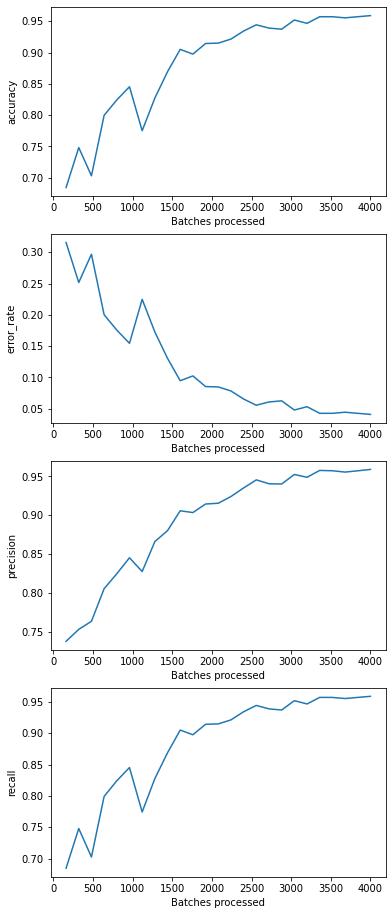

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)

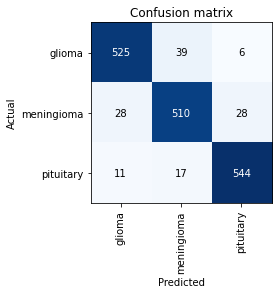

In [ ]:
interp.plot_confusion_matrix()
plt.savefig('/content/drive/My Drive/CSC400/5Conv_2Lin_128_input_CF.png')

In [ ]:
for i,c in enumerate(data.classes):
    print(f"Class {c} ({i}) accuracy: {round(sum(np.argmax(preds[y==i], axis = 1) == y[y==i]).numpy()/len(y[y==i]), 4)}")

Class glioma (0) accuracy: 0.9211
Class meningioma (1) accuracy: 0.9011
Class pituitary (2) accuracy: 0.951


Evaluating Model on Test Set

In [ ]:
loss, accuracy, precision, recall = learner.validate(data_test.valid_dl, metrics=[accuracy, Precision(), Recall()])

/usr/local/lib/python3.7/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [ ]:
print(accuracy)
print(precision)
print(recall)
print(loss)

tensor(0.9298)
tensor(0.9296)
tensor(0.9297)
0.17788824


In [ ]:
learner.data = data_test

In [ ]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)

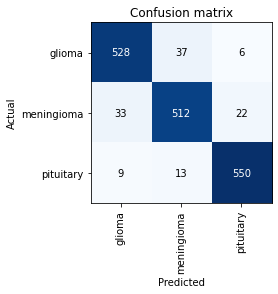

In [ ]:
interp.plot_confusion_matrix()
plt.savefig('/content/drive/My Drive/CSC400/5Conv_2Lin_128_input_Test_CF.png')

In [ ]:
for i,c in enumerate(data.classes):
    print(f"Class {c} ({i}) accuracy: {round(sum(np.argmax(preds[y==i], axis = 1) == y[y==i]).numpy()/len(y[y==i]), 4)}")

Class glioma (0) accuracy: 0.9247
Class meningioma (1) accuracy: 0.903
Class pituitary (2) accuracy: 0.9615
